# IMPORTS AND SETUP

In [1]:
%matplotlib inline
import pandas as pd
import random
import tkinter as tk
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [2]:
random_seed = random.randrange(100000000)
print(random_seed)
# random_seed = 222

87348926


In [3]:
unclean_detailed_info = pd.read_csv('..\Resources\BoardGames\games_detailed_info.csv')

In [4]:
clean_detailed_info = unclean_detailed_info.drop(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher', 'boardgameintegration', 'boardgamecompilation', 'boardgamecategory',
       'boardgamemechanic', 'boardgamefamily', 'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
       'Commodore 64 Rank', 'Arcade Rank', 'Atari ST Rank'], axis=1)

# FUNCTIONS

In [5]:
def sum_of_array(an_array):
    sum = 0 
    for i in an_array:
        sum += i
    return sum

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [7]:
language_value = {
    'NO' : 1,
    'SOME' : 2,
    'MODERATE' : 3,
    'EXTENSIVE' : 4,
    'UNPLAYABLE' : 5
}

def normalize_language_dependence(game):
    sum_of_weighted_language = 0
    total_num_votes = 0
    for level in game:
        value_key = level['@value'].split(' ')[0].upper()
        language_multiplier = language_value[value_key]
        votes = int(level['@numvotes'])
        total_num_votes += votes
        sum_of_weighted_language += language_multiplier * votes
    return (sum_of_weighted_language / total_num_votes) if total_num_votes > 0 else 0

In [8]:
def add_brackets_and_eval(string_item):
    string_item = str(string_item)
    if string_item[0] != '[':
        string_item = '[' + str(string_item)
    if string_item[-1] != ']':
        string_item = str(string_item) + ']'
    return eval(string_item)

In [9]:
def is_empty_playercount(game):
    for playercount in game:
        if 'result' in playercount:
            return True
        else: 
            return False

In [10]:
def calculate_age_from_ordered_dict(game):
    weighted_age_sum = 0
    total_votes = 0
    for age in game:
        votes = age['@numvotes']
        if age['@value'].isnumeric():
            age_num = age['@value']
        else:
            age_num = 25
        weighted_age_sum += int(age_num) * int(votes) 
        total_votes += int(votes)
    if total_votes:
        return weighted_age_sum/total_votes
    else:
        return 0

In [11]:
result_value = {
    'BEST' : 3,
    'RECOMMENDED' : 2,
    'NOTRECOMMENDED' : 1   
}

def calculate_players_from_ordered_dict(game):
    playercount_normalized_results = {}
    for playercount in game:
        if not 'result' in playercount:
            return 0
        total_votes = 0
        result_total_result = 0
        result_normalized_result = 0
        for result in playercount['result']:
            current_player_count = result['@value']
            multiplier = result_value[result['@value'].upper().replace(' ', '')]
            total_votes += int(result['@numvotes'])
            result_total_result += int(result['@numvotes']) * multiplier
        if(total_votes):
            result_normalized_result = result_total_result / total_votes
        else:
            result_normalized_result = 0
            result_normalized_result = 0
        playercount_normalized_results[playercount['@numplayers']]=result_normalized_result
    sum_of_weighted_players = 0
    sum_of_keys = 0
    num_of_keys = 0
    for key in playercount_normalized_results.keys():
        if not key.isnumeric():
            num = int(key[:-1]) + 1
        else:
            num = int(key)
        sum_of_weighted_players += num * (playercount_normalized_results[key]/3)
        sum_of_keys += num
        num_of_keys += 1
    return (sum_of_weighted_players)/(sum_of_keys/num_of_keys)


# DATA CLEANING

In [12]:
clean_detailed_info = clean_detailed_info.fillna(0)

In [13]:
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(calculate_players_from_ordered_dict)

In [14]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] != 0]
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(calculate_age_from_ordered_dict)

In [15]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] != 0]
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(normalize_language_dependence)

In [16]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_num_players'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] > 0]

# PRINTOUTS

In [17]:
print(unclean_detailed_info.columns)
print(unclean_detailed_info)

Index(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage',
       'suggested_language_dependence', 'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher',
       'usersrated', 'average', 'bayesaverage', 'Board Game Rank',
       'Strategy Game Rank', 'Family Game Rank', 'stddev', 'median', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight', 'boardgameintegration', 'boardgamecompilation',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank',
       'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
       'Commod

In [18]:
print(clean_detailed_info.columns)
print(clean_detailed_info)

Index(['minplayers', 'maxplayers', 'suggested_num_players',
       'suggested_playerage', 'suggested_language_dependence', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'usersrated', 'average',
       'bayesaverage', 'Board Game Rank', 'Strategy Game Rank',
       'Family Game Rank', 'stddev', 'median', 'owned', 'trading', 'wanting',
       'wishing', 'numcomments', 'numweights', 'averageweight',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank'],
      dtype='object')
       minplayers  maxplayers  suggested_num_players  suggested_playerage  \
0               2           4               3.294766             9.734205   
1               2           5               3.650544             7.615527   
2               3           4               3.075150             8.862408   
3               2           7               5.159062            10.004464   
4               2           4             

In [19]:
clean_detailed_info.shape[0]

12091

In [20]:
clean_detailed_info

,minplayers,maxplayers,suggested_num_players,suggested_playerage,suggested_language_dependence,playingtime,minplaytime,maxplaytime,minage,usersrated,...,wishing,numcomments,numweights,averageweight,Party Game Rank,Abstract Game Rank,Thematic Rank,War Game Rank,Customizable Rank,Children's Game Rank
0,2,4,3.294766,9.734205,2.130573,45,45,45,8,96241,...,8571,15778,5232,2.4148,0.0,0.0,0.0,0.0,0.0,0.0
1,2,5,3.650544,7.615527,1.028698,45,30,45,7,96228,...,6286,17720,7304,1.9158,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4,3.075150,8.862408,2.034268,120,60,120,10,96213,...,5310,17859,7187,2.3264,0.0,0.0,0.0,0.0,0.0,0.0
3,2,7,5.159062,10.004464,1.251295,30,30,30,10,79873,...,10875,13304,4423,2.3321,0.0,0.0,0.0,0.0,0.0,0.0
4,2,4,3.181440,9.691038,3.145585,30,30,30,13,74959,...,7607,13008,4850,2.3586,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19222,2,2,2.333333,16.000000,3.500000,0,0,0,12,30,...,30,19,9,2.4444,0.0,0.0,0.0,2373.0,0.0,0.0
19225,2,4,3.000000,8.000000,1.000000,0,0,0,7,30,...,4,4,1,1.0000,0.0,0.0,0.0,0.0,0.0,0.0
19226,2,5,3.809524,8.000000,2.000000,30,15,30,10,30,...,1,13,2,2.0000,0.0,0.0,0.0,0.0,0.0,0.0
19227,3,8,3.133333,6.000000,1.000000,20,20,20,8,30,...,6,10,1,1.0000,0.0,0.0,0.0,0.0,0.0,0.0


# APPLICATION

# TESTING

In [21]:
print(clean_detailed_info.columns)
# clean_detailed_info[clean_detailed_info['Customizable Rank'] > 0]

Index(['minplayers', 'maxplayers', 'suggested_num_players',
       'suggested_playerage', 'suggested_language_dependence', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'usersrated', 'average',
       'bayesaverage', 'Board Game Rank', 'Strategy Game Rank',
       'Family Game Rank', 'stddev', 'median', 'owned', 'trading', 'wanting',
       'wishing', 'numcomments', 'numweights', 'averageweight',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank'],
      dtype='object')


In [22]:
scaled_set = StandardScaler().fit_transform(clean_detailed_info)
pca_set = PCA(n_components=2, random_state=random_seed)
principalComponentsGames = pca_set.fit_transform(scaled_set)
principalComponentsGamesDF = pd.DataFrame(data=principalComponentsGames, columns = ['PC1', 'PC2'])
train_set, test_set = train_test_split(principalComponentsGamesDF, test_size=0.2, random_state=random_seed, shuffle=True)


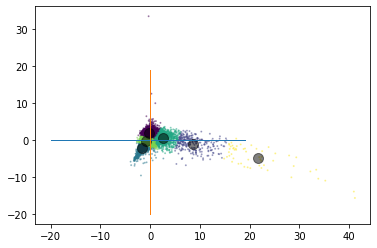

In [51]:
kmeans = KMeans(n_clusters=6, random_state=random_seed)
kmeans.fit(train_set)
y_kmeans = kmeans.predict(train_set)

plt.scatter(train_set.iloc[:, 0], train_set.iloc[:, 1], c=y_kmeans, s=1, alpha=.4, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

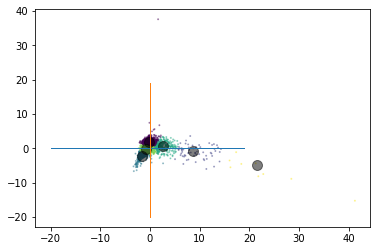

In [52]:
y_testkmeans = kmeans.predict(test_set)
plt.scatter(test_set.iloc[:, 0], test_set.iloc[:, 1], c=y_testkmeans, s=1, alpha=.4, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [25]:
reg = LinearRegression().fit(train_set, y_kmeans)
print(reg.score(train_set, y_kmeans))
print(reg.predict(test_set))
print(y_testkmeans)

0.20151358817870513
[1.36203074 1.89786869 2.93957793 ... 2.59526176 1.37194347 2.10591083]
[0 4 2 ... 4 0 1]


5
0
8.459984595093973
-13.640492624600668
1.415777738216416


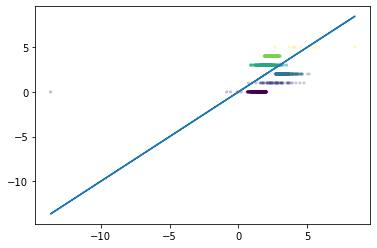

In [39]:
new_array = []
pred_vals = reg.predict(test_set)
for i in range(0,len(pred_vals)):
    new_array.append(abs(y_testkmeans[i] - pred_vals[i]))

print(max(y_testkmeans))
print(min(y_testkmeans))
print(max(pred_vals))
print(min(pred_vals))
print(sum_of_array(new_array)/len(new_array))

plt.scatter(pred_vals, y_testkmeans, c=y_testkmeans, s=5, alpha=.2, marker='o')
plt.plot(pred_vals, pred_vals, '-')

SUSPECT best option is to round down if <2.5 or >5 and up if >2.5 or <0 unless 

In [27]:
for i in range(0,len(pred_vals)):
    print('\n\n####################################################################################\n\n')
    print('y= '+str(y_testkmeans[i]))
    print('x= '+str(pred_vals[i]))
    print('difference= '+str(y_testkmeans[i] - pred_vals[i]))
    print('\n\n')
    print('absy= '+str(abs(y_testkmeans[i])))
    print('absx= '+str(abs(pred_vals[i])))
    print('absdifference= '+str(abs(y_testkmeans[i] - pred_vals[i])))
    print('\n\n')
    print('absdifabs= '+str(abs(abs(y_testkmeans[i]) - abs(pred_vals[i]))))




####################################################################################


y= 0
x= 1.3620307431044973
difference= -1.3620307431044973



absy= 0
absx= 1.3620307431044973
absdifference= 1.3620307431044973



absdifabs= 1.3620307431044973


####################################################################################


y= 4
x= 1.8978686872559598
difference= 2.1021313127440404



absy= 4
absx= 1.8978686872559598
absdifference= 2.1021313127440404



absdifabs= 2.1021313127440404


####################################################################################


y= 2
x= 2.9395779309246084
difference= -0.9395779309246084



absy= 2
absx= 2.9395779309246084
absdifference= 0.9395779309246084



absdifabs= 0.9395779309246084


####################################################################################


y= 0
x= 1.6708094596409644
difference= -1.6708094596409644



absy= 0
absx= 1.6708094596409644
absdifference= 1.6708094596409644



absdifabs= 1.67080945964096

y= 0
x= 1.39830162107733
difference= -1.39830162107733



absy= 0
absx= 1.39830162107733
absdifference= 1.39830162107733



absdifabs= 1.39830162107733


####################################################################################


y= 3
x= 2.383351973975608
difference= 0.6166480260243921



absy= 3
absx= 2.383351973975608
absdifference= 0.6166480260243921



absdifabs= 0.6166480260243921


####################################################################################


y= 0
x= 1.5852086809016361
difference= -1.5852086809016361



absy= 0
absx= 1.5852086809016361
absdifference= 1.5852086809016361



absdifabs= 1.5852086809016361


####################################################################################


y= 4
x= 2.4571355797278094
difference= 1.5428644202721906



absy= 4
absx= 2.4571355797278094
absdifference= 1.5428644202721906



absdifabs= 1.5428644202721906


####################################################################################


y= 0
x= 1.

absy= 2
absx= 2.7610361179820897
absdifference= 0.7610361179820897



absdifabs= 0.7610361179820897


####################################################################################


y= 3
x= 2.2405791130350616
difference= 0.7594208869649384



absy= 3
absx= 2.2405791130350616
absdifference= 0.7594208869649384



absdifabs= 0.7594208869649384


####################################################################################


y= 4
x= 2.1889864677204747
difference= 1.8110135322795253



absy= 4
absx= 2.1889864677204747
absdifference= 1.8110135322795253



absdifabs= 1.8110135322795253


####################################################################################


y= 2
x= 2.892823310231659
difference= -0.892823310231659



absy= 2
absx= 2.892823310231659
absdifference= 0.892823310231659



absdifabs= 0.892823310231659


####################################################################################


y= 4
x= 2.3517504727838796
difference= 1.6482495272161204



absy




absy= 3
absx= 1.465766647040919
absdifference= 1.534233352959081



absdifabs= 1.534233352959081


####################################################################################


y= 3
x= 2.5939522256644296
difference= 0.4060477743355704



absy= 3
absx= 2.5939522256644296
absdifference= 0.4060477743355704



absdifabs= 0.4060477743355704


####################################################################################


y= 4
x= 1.9862442210097022
difference= 2.013755778990298



absy= 4
absx= 1.9862442210097022
absdifference= 2.013755778990298



absdifabs= 2.013755778990298


####################################################################################


y= 4
x= 2.777945101354597
difference= 1.222054898645403



absy= 4
absx= 2.777945101354597
absdifference= 1.222054898645403



absdifabs= 1.222054898645403


####################################################################################


y= 4
x= 2.679361987078175
difference= 1.3206380129218251



absy= 4
a

x= 1.3228662637445976
difference= -1.3228662637445976



absy= 0
absx= 1.3228662637445976
absdifference= 1.3228662637445976



absdifabs= 1.3228662637445976


####################################################################################


y= 4
x= 2.211440383981729
difference= 1.7885596160182708



absy= 4
absx= 2.211440383981729
absdifference= 1.7885596160182708



absdifabs= 1.7885596160182708


####################################################################################


y= 2
x= 2.9755941698211306
difference= -0.9755941698211306



absy= 2
absx= 2.9755941698211306
absdifference= 0.9755941698211306



absdifabs= 0.9755941698211306


####################################################################################


y= 4
x= 2.0046691616401002
difference= 1.9953308383598998



absy= 4
absx= 2.0046691616401002
absdifference= 1.9953308383598998



absdifabs= 1.9953308383598998


####################################################################################


y= 4


x= 2.9825141614973942
difference= -0.9825141614973942



absy= 2
absx= 2.9825141614973942
absdifference= 0.9825141614973942



absdifabs= 0.9825141614973942


####################################################################################


y= 0
x= 1.5551195943351193
difference= -1.5551195943351193



absy= 0
absx= 1.5551195943351193
absdifference= 1.5551195943351193



absdifabs= 1.5551195943351193


####################################################################################


y= 0
x= 1.9302684119679414
difference= -1.9302684119679414



absy= 0
absx= 1.9302684119679414
absdifference= 1.9302684119679414



absdifabs= 1.9302684119679414


####################################################################################


y= 2
x= 4.2012032563698805
difference= -2.2012032563698805



absy= 2
absx= 4.2012032563698805
absdifference= 2.2012032563698805



absdifabs= 2.2012032563698805


####################################################################################


y

y= 4
x= 2.6996148706288565
difference= 1.3003851293711435



absy= 4
absx= 2.6996148706288565
absdifference= 1.3003851293711435



absdifabs= 1.3003851293711435


####################################################################################


y= 0
x= 1.008139152540985
difference= -1.008139152540985



absy= 0
absx= 1.008139152540985
absdifference= 1.008139152540985



absdifabs= 1.008139152540985


####################################################################################


y= 2
x= 3.012605732476725
difference= -1.0126057324767248



absy= 2
absx= 3.012605732476725
absdifference= 1.0126057324767248



absdifabs= 1.0126057324767248


####################################################################################


y= 0
x= 1.2523898447769024
difference= -1.2523898447769024



absy= 0
absx= 1.2523898447769024
absdifference= 1.2523898447769024



absdifabs= 1.2523898447769024


####################################################################################


y= 4

absdifference= 0.9859048136019837



absdifabs= 0.9859048136019837


####################################################################################


y= 2
x= 3.210650297476869
difference= -1.2106502974768691



absy= 2
absx= 3.210650297476869
absdifference= 1.2106502974768691



absdifabs= 1.2106502974768691


####################################################################################


y= 2
x= 3.233039023760976
difference= -1.233039023760976



absy= 2
absx= 3.233039023760976
absdifference= 1.233039023760976



absdifabs= 1.233039023760976


####################################################################################


y= 0
x= 1.5722595483624242
difference= -1.5722595483624242



absy= 0
absx= 1.5722595483624242
absdifference= 1.5722595483624242



absdifabs= 1.5722595483624242


####################################################################################


y= 4
x= 2.31289913101418
difference= 1.6871008689858198



absy= 4
absx= 2.31289913101418
absdiffe

difference= 1.983988435562317



absy= 4
absx= 2.016011564437683
absdifference= 1.983988435562317



absdifabs= 1.983988435562317


####################################################################################


y= 3
x= 1.3471459796354424
difference= 1.6528540203645576



absy= 3
absx= 1.3471459796354424
absdifference= 1.6528540203645576



absdifabs= 1.6528540203645576


####################################################################################


y= 2
x= 2.8214467209419265
difference= -0.8214467209419265



absy= 2
absx= 2.8214467209419265
absdifference= 0.8214467209419265



absdifabs= 0.8214467209419265


####################################################################################


y= 3
x= 2.0914169175791595
difference= 0.9085830824208405



absy= 3
absx= 2.0914169175791595
absdifference= 0.9085830824208405



absdifabs= 0.9085830824208405


####################################################################################


y= 4
x= 2.6221188878256942
dif

absdifference= 1.34529455574161



absdifabs= 1.34529455574161


####################################################################################


y= 4
x= 2.4389620778091663
difference= 1.5610379221908337



absy= 4
absx= 2.4389620778091663
absdifference= 1.5610379221908337



absdifabs= 1.5610379221908337


####################################################################################


y= 3
x= 2.200675600311717
difference= 0.7993243996882828



absy= 3
absx= 2.200675600311717
absdifference= 0.7993243996882828



absdifabs= 0.7993243996882828


####################################################################################


y= 0
x= 1.9165871868440087
difference= -1.9165871868440087



absy= 0
absx= 1.9165871868440087
absdifference= 1.9165871868440087



absdifabs= 1.9165871868440087


####################################################################################


y= 4
x= 2.050604614330957
difference= 1.949395385669043



absy= 4
absx= 2.050604614330957
absdiffe

x= 2.9285682147653485
difference= 1.0714317852346515



absy= 4
absx= 2.9285682147653485
absdifference= 1.0714317852346515



absdifabs= 1.0714317852346515


####################################################################################


y= 4
x= 2.8936294485075713
difference= 1.1063705514924287



absy= 4
absx= 2.8936294485075713
absdifference= 1.1063705514924287



absdifabs= 1.1063705514924287


####################################################################################


y= 0
x= 1.4171938596120746
difference= -1.4171938596120746



absy= 0
absx= 1.4171938596120746
absdifference= 1.4171938596120746



absdifabs= 1.4171938596120746


####################################################################################


y= 0
x= 1.7670569633444497
difference= -1.7670569633444497



absy= 0
absx= 1.7670569633444497
absdifference= 1.7670569633444497



absdifabs= 1.7670569633444497


####################################################################################


y= 

absdifabs= 1.5886989124878206


####################################################################################


y= 0
x= 1.8735796325580667
difference= -1.8735796325580667



absy= 0
absx= 1.8735796325580667
absdifference= 1.8735796325580667



absdifabs= 1.8735796325580667


####################################################################################


y= 0
x= 1.465202708152121
difference= -1.465202708152121



absy= 0
absx= 1.465202708152121
absdifference= 1.465202708152121



absdifabs= 1.465202708152121


####################################################################################


y= 4
x= 1.988911857118864
difference= 2.0110881428811362



absy= 4
absx= 1.988911857118864
absdifference= 2.0110881428811362



absdifabs= 2.0110881428811362


####################################################################################


y= 0
x= 1.5773977906441892
difference= -1.5773977906441892



absy= 0
absx= 1.5773977906441892
absdifference= 1.5773977906441892



absd




absdifabs= 0.11742663213462379


####################################################################################


y= 3
x= 2.8115201114807165
difference= 0.18847988851928354



absy= 3
absx= 2.8115201114807165
absdifference= 0.18847988851928354



absdifabs= 0.18847988851928354


####################################################################################


y= 4
x= 2.5202505912187183
difference= 1.4797494087812817



absy= 4
absx= 2.5202505912187183
absdifference= 1.4797494087812817



absdifabs= 1.4797494087812817


####################################################################################


y= 4
x= 2.4993807444672433
difference= 1.5006192555327567



absy= 4
absx= 2.4993807444672433
absdifference= 1.5006192555327567



absdifabs= 1.5006192555327567


####################################################################################


y= 2
x= 3.372840361537836
difference= -1.3728403615378362



absy= 2
absx= 3.372840361537836
absdifference= 1.37284036153783




absdifabs= 0.7636830355628925


####################################################################################


y= 4
x= 2.2521114025404185
difference= 1.7478885974595815



absy= 4
absx= 2.2521114025404185
absdifference= 1.7478885974595815



absdifabs= 1.7478885974595815


####################################################################################


y= 3
x= 2.4216307306889204
difference= 0.5783692693110796



absy= 3
absx= 2.4216307306889204
absdifference= 0.5783692693110796



absdifabs= 0.5783692693110796


####################################################################################


y= 2
x= 2.926647978045413
difference= -0.9266479780454131



absy= 2
absx= 2.926647978045413
absdifference= 0.9266479780454131



absdifabs= 0.9266479780454131


####################################################################################


y= 3
x= 2.6529412475464937
difference= 0.34705875245350626



absy= 3
absx= 2.6529412475464937
absdifference= 0.34705875245350626



####################################################################################


y= 0
x= 1.6900330274115245
difference= -1.6900330274115245



absy= 0
absx= 1.6900330274115245
absdifference= 1.6900330274115245



absdifabs= 1.6900330274115245


####################################################################################


y= 4
x= 2.5497903026600652
difference= 1.4502096973399348



absy= 4
absx= 2.5497903026600652
absdifference= 1.4502096973399348



absdifabs= 1.4502096973399348


####################################################################################


y= 2
x= 3.0794560559583046
difference= -1.0794560559583046



absy= 2
absx= 3.0794560559583046
absdifference= 1.0794560559583046



absdifabs= 1.0794560559583046


####################################################################################


y= 2
x= 3.9640348841041826
difference= -1.9640348841041826



absy= 2
absx= 3.9640348841041826
absdifference= 1.9640348841041826



absdifabs= 1.96403488410418


absdifabs= 1.1685985690805165


####################################################################################


y= 0
x= 1.696955350384067
difference= -1.696955350384067



absy= 0
absx= 1.696955350384067
absdifference= 1.696955350384067



absdifabs= 1.696955350384067


####################################################################################


y= 0
x= 1.8808633232803273
difference= -1.8808633232803273



absy= 0
absx= 1.8808633232803273
absdifference= 1.8808633232803273



absdifabs= 1.8808633232803273


####################################################################################


y= 0
x= 1.675819902066392
difference= -1.675819902066392



absy= 0
absx= 1.675819902066392
absdifference= 1.675819902066392



absdifabs= 1.675819902066392


####################################################################################


y= 4
x= 2.0940383415085044
difference= 1.9059616584914956



absy= 4
absx= 2.0940383415085044
absdifference= 1.9059616584914956



absdif

absdifabs= 0.17874023796487126


####################################################################################


y= 4
x= 2.294944989658433
difference= 1.705055010341567



absy= 4
absx= 2.294944989658433
absdifference= 1.705055010341567



absdifabs= 1.705055010341567


####################################################################################


y= 2
x= 3.1468546398415835
difference= -1.1468546398415835



absy= 2
absx= 3.1468546398415835
absdifference= 1.1468546398415835



absdifabs= 1.1468546398415835


####################################################################################


y= 4
x= 2.4663686362576804
difference= 1.5336313637423196



absy= 4
absx= 2.4663686362576804
absdifference= 1.5336313637423196



absdifabs= 1.5336313637423196


####################################################################################


y= 4
x= 2.1504130429265507
difference= 1.8495869570734493



absy= 4
absx= 2.1504130429265507
absdifference= 1.8495869570734493



abs

y= 0
x= 1.4801825479990312
difference= -1.4801825479990312



absy= 0
absx= 1.4801825479990312
absdifference= 1.4801825479990312



absdifabs= 1.4801825479990312


####################################################################################


y= 2
x= 2.7768505595849566
difference= -0.7768505595849566



absy= 2
absx= 2.7768505595849566
absdifference= 0.7768505595849566



absdifabs= 0.7768505595849566


####################################################################################


y= 0
x= 1.8439130111538375
difference= -1.8439130111538375



absy= 0
absx= 1.8439130111538375
absdifference= 1.8439130111538375



absdifabs= 1.8439130111538375


####################################################################################


y= 4
x= 2.44532234616505
difference= 1.55467765383495



absy= 4
absx= 2.44532234616505
absdifference= 1.55467765383495



absdifabs= 1.55467765383495


####################################################################################


y= 2
x=


absy= 4
absx= 2.5211816644134664
absdifference= 1.4788183355865336



absdifabs= 1.4788183355865336


####################################################################################


y= 0
x= 1.339601468937233
difference= -1.339601468937233



absy= 0
absx= 1.339601468937233
absdifference= 1.339601468937233



absdifabs= 1.339601468937233


####################################################################################


y= 4
x= 2.7439170730184923
difference= 1.2560829269815077



absy= 4
absx= 2.7439170730184923
absdifference= 1.2560829269815077



absdifabs= 1.2560829269815077


####################################################################################


y= 3
x= 2.793744354689462
difference= 0.20625564531053797



absy= 3
absx= 2.793744354689462
absdifference= 0.20625564531053797



absdifabs= 0.20625564531053797


####################################################################################


y= 3
x= 2.47502840227862
difference= 0.5249715977213798



absy

x= 2.878440801892989
difference= -0.8784408018929888



absy= 2
absx= 2.878440801892989
absdifference= 0.8784408018929888



absdifabs= 0.8784408018929888


####################################################################################


y= 2
x= 2.836284904215935
difference= -0.836284904215935



absy= 2
absx= 2.836284904215935
absdifference= 0.836284904215935



absdifabs= 0.836284904215935


####################################################################################


y= 2
x= 2.9150599391037098
difference= -0.9150599391037098



absy= 2
absx= 2.9150599391037098
absdifference= 0.9150599391037098



absdifabs= 0.9150599391037098


####################################################################################


y= 4
x= 2.722747387387632
difference= 1.2772526126123682



absy= 4
absx= 2.722747387387632
absdifference= 1.2772526126123682



absdifabs= 1.2772526126123682


####################################################################################


y= 0
x= 1.3